# Gensim Word2Vec Tutorial


<img src="https://images.freeimages.com/images/large-previews/2b9/letters-1-yes-1188348.jpg" alt="drawing" width="350"/>

# Plan

1. [Briefing about Word2Vec](#Briefing-about-Word2Vec:)
    * [Purpose of the tutorial](#Purpose-of-the-tutorial:)
    * [Brief explanation](#Brief-explanation:)

2. [Getting Started](#Getting-Started)
    * [Setting up the environment](#Setting-up-the-environment:)
    * [The data](#The-data:)
3. [Preprocessing](#Preprocessing)
    * [Cleaning](#Cleaning)
    * [Bigrams](#Bigrams)
    * [Most frequent words](#Most-Frequent-Words)
    
4. [Training the Model](#Training-the-model)
    * [Gensim Word2Vec Implementation](#Gensim-Word2Vec-Implementation:)
    * [Why I seperate the training of the model in 3 steps](#Why-I-seperate-the-training-of-the-model-in-3-steps:)
    * [Training the model](#Training-the-model)
        * [The parameters](#The-parameters)
        * [Building the vocabulary table](#Building-the-Vocabulary-Table)
        * [Training of the model](#Training-of-the-model)
        * [Saving the model](#Saving-the-model:)
5. [Exploring the Model](#Exploring-the-model)
    * [Most similar to](#Most-similar-to:)
    * [Similarities](#Similarities:)
    * [Odd-one-out](#Odd-One-Out:)
    * [Analogy difference](#Analogy-difference:)
    * [t-SNE visualizations](#t-SNE-visualizations:)
        * [10 Most similar words vs. 8 Random words](#10-Most-similar-words-vs.-8-Random-words:)
        * [10 Most similar words vs. 10 Most dissimilar](#10-Most-similar-words-vs.-10-Most-dissimilar:)
        * [10 Most similar words vs. 11th to 20th Most similar words](#10-Most-similar-words-vs.-11th-to-20th-Most-similar-words:)
6. [Final Thoughts](#Final-Thoughts)
7. [Material for more in depths understanding](#Material-for-more-in-depths-understanding:)
8. [Acknowledgements](#Acknowledgements)
9. [References](#References:)
10. [End](#End)

# Briefing about Word2Vec:

<img src="http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png" alt="drawing" width="550"/>

[[1]](#References:)




## Brief explanation:

Word2Vec was introduced in two [papers](#Material-for-more-in-depths-understanding:) between September and October 2013, by a team of researchers at Google. Along with the papers, the researchers published their implementation in C. The Python implementation was done soon after the 1st paper, by [Gensim](https://radimrehurek.com/gensim/index.html). 

The underlying assumption of Word2Vec is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model. For instance: "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2Vec they will therefore share a similar vector representation.<br>

From this assumption, Word2Vec can be used to find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering.

# Getting Started

## Setting up the environment:

`python==3.6.3`

Libraries used:
 * `xlrd==1.1.0`: https://pypi.org/project/xlrd/
 * `spaCy==2.0.12`: https://spacy.io/usage/
 * `gensim==3.4.0`: https://radimrehurek.com/gensim/install.html
 * `scikit-learn==0.19.1`: http://scikit-learn.org/stable/install.html
 * `seaborn==0.8`: https://seaborn.pydata.org/installing.html

In [3]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

<img src="https://upload.wikimedia.org/wikipedia/commons/4/44/Logo_The_Simpsons.svg" alt="drawing" width="400"/>

## The data:
I chose to play with the script from the Simpsons, both because I love the Simpsons and because with more than 150k lines of dialogues, the dataset was substantial!

This dataset contains the characters, locations, episode details, and script lines for approximately 600 Simpsons episodes, dating back to 1989. It can be found here: https://www.kaggle.com/ambarish/fun-in-text-mining-with-simpsons/data (~25MB)

# Preprocessing

We keep only two columns:
* `raw_character_text`: the character who speaks (can be useful when monitoring the preprocessing steps)
* `spoken_words`: the raw text from the line of dialogue

We do not keep `normalized_text` because we want to do our own preprocessing.

You can find the resulting file here: https://www.kaggle.com/pierremegret/dialogue-lines-of-the-simpsons

In [4]:
df = pd.read_csv('dataset.csv')
df.shape

(19581, 2)

In [5]:
df.head()

raw_character_text                                       spoken_words
0              Miss Hoover  No, actually, it was a little of both. Sometim...
1             Lisa Simpson                             Where's Mr. Bergstrom?
2              Miss Hoover  I don't know. Although I'd sure like to talk t...
3             Lisa Simpson                         That life is worth living.
4  Edna Krabappel-Flanders  The polls will be open from now until the end ...

The missing values comes from the part of the script where something happens, but with no dialogue. For instance "(Springfield Elementary School: EXT. ELEMENTARY - SCHOOL PLAYGROUND - AFTERNOON)"

In [6]:
df.isnull().sum()

raw_character_text    2447
spoken_words          3108
dtype: int64

Removing the missing values:

In [7]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

## Cleaning:
We are lemmatizing and removing the stopwords and non-alphabetic characters for each line of dialogue.

In [8]:
!python -m spacy download en_core_web_sm

2021-03-12 14:47:36.184023: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2021-03-12 14:47:36.184084: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2021-03-12 14:47:36.184092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
     |████████████████████████████████| 13.7 MB 4.7 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

Removes non-alphabetic characters:

In [10]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words']) #[^A-Za-z']+ 
brief_cleaning

<generator object <genexpr> at 0x7feff546be08>

Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:

In [11]:
t = time()
#use the method cleaning
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)] # n_thread=-1 to n_process ?

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.27 mins


Put the results in a DataFrame to remove missing values and duplicates:

In [12]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape
# 11017,1

(10223, 1)

## Bigrams:
We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.
https://radimrehurek.com/gensim/models/phrases.html

The main reason we do this is to catch words like "mr_burns" or "bart_simpson" !

In [13]:
from gensim.models.phrases import Phrases, Phraser

As `Phrases()` takes a list of list of words as input:

In [14]:
sent = [row.split() for row in df_clean['clean']]

In [15]:
print(len(sent))

10223


In [16]:
sent

[['actually',
  'little',
  'disease',
  'magazine',
  'news',
  'show',
  'natural',
  'think'],
 ['know', 'sure', 'like', 'talk', 'touch', 'lesson', 'plan', 'teach'],
 ['life', 'worth', 'live'],
 ['poll',
  'open',
  'end',
  'recess',
  'case',
  'decide',
  'thought',
  'final',
  'statement',
  'martin'],
 ['victory', 'party', 'slide'],
 ['mr', 'bergstrom', 'mr', 'bergstrom'],
 ['hey',
  'hey',
  'move',
  'morning',
  'new',
  'job',
  'take',
  'copernicus',
  'costume'],
 ['think', 'take', 'train', 'capital', 'city'],
 ['train', 'like', 'traditional', 'environmentally', 'sound'],
 ['yes',
  'backbone',
  'country',
  'leland',
  'stanford',
  'drive',
  'golden',
  'spike',
  'promontory',
  'point'],
 ['hey', 'thank', 'vote', 'man'],
 ['vote', 'voting', 'geek'],
 ['get', 'right', 'thank', 'vote', 'girl'],
 ['sweat', 'long', 'couple', 'people', 'right', 'milhouse'],
 ['martin', 'martin', 'like', 'recount'],
 ['want', 'sure', 'martin', 'martin'],
 ['way', 'mister', 'president'],

Creates the relevant phrases from the list of sentences:

In [14]:
phrases = Phrases(sent, min_count=5, progress_per=10000)

INFO - 14:13:22: collecting all words and their counts
INFO - 14:13:22: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 14:13:22: PROGRESS: at sentence #10000, processed 63557 words and 52733 word types
INFO - 14:13:22: collected 53734 word types from a corpus of 64985 words (unigram + bigrams) and 10223 sentences
INFO - 14:13:22: using 53734 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


In [15]:
phrases

The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:

In [16]:
bigram = Phraser(phrases)

INFO - 14:13:22: source_vocab length 53734
INFO - 14:13:23: Phraser built with 167 phrasegrams


In [17]:
bigram

Transform the corpus based on the bigrams detected:

In [18]:
sentences = bigram[sent]

In [19]:
sentences

## Most Frequent Words:
Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.

In [20]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)
# 9685

9601

In [21]:
word_freq

defaultdict(int,
            {'actually': 52,
             'little': 312,
             'disease': 4,
             'magazine': 20,
             'news': 31,
             'show': 17,
             'natural': 6,
             'think': 488,
             'know': 605,
             'sure': 153,
             'like': 546,
             'talk': 120,
             'touch': 15,
             'lesson': 20,
             'plan': 30,
             'teach': 31,
             'life': 149,
             'worth': 16,
             'live': 79,
             'poll': 2,
             'open': 54,
             'end': 56,
             'recess': 3,
             'case': 33,
             'decide': 23,
             'thought': 20,
             'final': 12,
             'statement': 1,
             'martin': 23,
             'victory': 3,
             'party': 42,
             'slide': 6,
             'mr_bergstrom': 7,
             'hey': 505,
             'move': 15,
             'morning': 32,
             'new': 157,
       

In [22]:
#display the 10 most present words
s_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
print(s_words[:10])
# ['be', 'not', 'will', 'oh', 'know', "'s", 'hey', 'think', 'good', 'homer']

[('oh', 736), ('know', 605), ('like', 546), ('hey', 505), ('think', 488), ('get', 475), ('homer', 462), ('right', 441), ('come', 440), ('bart', 424)]


# Training the model
## Gensim Word2Vec Implementation:
We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

In [23]:
import multiprocessing

from gensim.models import Word2Vec

## Why I seperate the training of the model in 3 steps:
I prefer to separate the training in 3 distinctive steps for clarity and monitoring.
1. `Word2Vec()`: 
>In this first step, I set up the parameters of the model one-by-one. <br>I do not supply the parameter `sentences`, and therefore leave the model uninitialized, purposefully.
2. `.build_vocab()`: 
>Here it builds the vocabulary from a sequence of sentences and thus initialized the model. <br>With the loggings, I can follow the progress and even more important, the effect of `min_count` and `sample` on the word corpus. I noticed that these two parameters, and in particular `sample`, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.
3. `.train()`:
>Finally, trains the model.<br>
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [24]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

12

## The parameters:

* `min_count` <font color='purple'>=</font> <font color='green'>int</font> - Ignores all words with total absolute frequency lower than this - (2, 100)


* `window` <font color='purple'>=</font> <font color='green'>int</font> - The maximum distance between the current and predicted word within a sentence. E.g. `window` words on the left and `window` words on the left of our target - (2, 10)


* `size` <font color='purple'>=</font> <font color='green'>int</font> - Dimensionality of the feature vectors. - (50, 300)


* `sample` <font color='purple'>=</font> <font color='green'>float</font> - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial.  - (0, 1e-5)


* `alpha` <font color='purple'>=</font> <font color='green'>float</font> - The initial learning rate - (0.01, 0.05)


* `min_alpha` <font color='purple'>=</font> <font color='green'>float</font> - Learning rate will linearly drop to `min_alpha` as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00


* `negative` <font color='purple'>=</font> <font color='green'>int</font> - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)


* `workers` <font color='purple'>=</font> <font color='green'>int</font> - Use these many worker threads to train the model (=faster training with multicore machines)

In [25]:
len(sentences)

10223

In [26]:
w2v_model = Word2Vec(min_count=10,
                     window=2,
                     size=300, #len(sentences),
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=5,
                     workers=cores-1)

## Building the Vocabulary Table:
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [27]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 14:13:23: collecting all words and their counts
INFO - 14:13:23: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 14:13:23: PROGRESS: at sentence #10000, processed 61111 words, keeping 9509 word types
INFO - 14:13:23: collected 9601 word types from a corpus of 62481 raw words and 10223 sentences
INFO - 14:13:23: Loading a fresh vocabulary
INFO - 14:13:23: effective_min_count=10 retains 1111 unique words (11% of original 9601, drops 8490)
INFO - 14:13:23: effective_min_count=10 leaves 43872 word corpus (70% of original 62481, drops 18609)
INFO - 14:13:23: deleting the raw counts dictionary of 9601 items
INFO - 14:13:23: sample=6e-05 downsamples 1111 most-common words
INFO - 14:13:23: downsampling leaves estimated 12767 word corpus (29.1% of prior 43872)
INFO - 14:13:23: estimated required memory for 1111 words and 300 dimensions: 3221900 bytes
INFO - 14:13:23: resetting layer weights


Time to build vocab: 0.01 mins


## Training of the model:
_Parameters of the training:_
* `total_examples` <font color='purple'>=</font> <font color='green'>int</font> - Count of sentences;
* `epochs` <font color='purple'>=</font> <font color='green'>int</font> - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [28]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1) # 100 epochs in example

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 14:13:24: training model with 11 workers on 1111 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=5 window=2
INFO - 14:13:24: worker thread finished; awaiting finish of 10 more threads
INFO - 14:13:24: worker thread finished; awaiting finish of 9 more threads
INFO - 14:13:24: worker thread finished; awaiting finish of 8 more threads
INFO - 14:13:24: worker thread finished; awaiting finish of 7 more threads
INFO - 14:13:24: worker thread finished; awaiting finish of 6 more threads
INFO - 14:13:24: worker thread finished; awaiting finish of 5 more threads
INFO - 14:13:24: worker thread finished; awaiting finish of 4 more threads
INFO - 14:13:24: worker thread finished; awaiting finish of 3 more threads
INFO - 14:13:24: worker thread finished; awaiting finish of 2 more threads
INFO - 14:13:24: worker thread finished; awaiting finish of 1 more threads
INFO - 14:13:24: worker thread finished; awaiting finish of 0 more threads
INFO - 14:13:24: EPOCH - 1 : training on

INFO - 14:13:27: worker thread finished; awaiting finish of 3 more threads
INFO - 14:13:27: worker thread finished; awaiting finish of 2 more threads
INFO - 14:13:27: worker thread finished; awaiting finish of 1 more threads
INFO - 14:13:27: worker thread finished; awaiting finish of 0 more threads
INFO - 14:13:27: EPOCH - 9 : training on 62481 raw words (12748 effective words) took 0.3s, 37277 effective words/s
INFO - 14:13:27: worker thread finished; awaiting finish of 10 more threads
INFO - 14:13:27: worker thread finished; awaiting finish of 9 more threads
INFO - 14:13:27: worker thread finished; awaiting finish of 8 more threads
INFO - 14:13:27: worker thread finished; awaiting finish of 7 more threads
INFO - 14:13:27: worker thread finished; awaiting finish of 6 more threads
INFO - 14:13:27: worker thread finished; awaiting finish of 5 more threads
INFO - 14:13:27: worker thread finished; awaiting finish of 4 more threads
INFO - 14:13:27: worker thread finished; awaiting finish o

INFO - 14:13:30: worker thread finished; awaiting finish of 6 more threads
INFO - 14:13:30: worker thread finished; awaiting finish of 5 more threads
INFO - 14:13:30: worker thread finished; awaiting finish of 4 more threads
INFO - 14:13:30: worker thread finished; awaiting finish of 3 more threads
INFO - 14:13:30: worker thread finished; awaiting finish of 2 more threads
INFO - 14:13:30: worker thread finished; awaiting finish of 1 more threads
INFO - 14:13:30: worker thread finished; awaiting finish of 0 more threads
INFO - 14:13:30: EPOCH - 18 : training on 62481 raw words (12687 effective words) took 0.3s, 41213 effective words/s
INFO - 14:13:30: worker thread finished; awaiting finish of 10 more threads
INFO - 14:13:30: worker thread finished; awaiting finish of 9 more threads
INFO - 14:13:30: worker thread finished; awaiting finish of 8 more threads
INFO - 14:13:30: worker thread finished; awaiting finish of 7 more threads
INFO - 14:13:30: worker thread finished; awaiting finish 

INFO - 14:13:33: worker thread finished; awaiting finish of 9 more threads
INFO - 14:13:33: worker thread finished; awaiting finish of 8 more threads
INFO - 14:13:33: worker thread finished; awaiting finish of 7 more threads
INFO - 14:13:33: worker thread finished; awaiting finish of 6 more threads
INFO - 14:13:33: worker thread finished; awaiting finish of 5 more threads
INFO - 14:13:33: worker thread finished; awaiting finish of 4 more threads
INFO - 14:13:33: worker thread finished; awaiting finish of 3 more threads
INFO - 14:13:33: worker thread finished; awaiting finish of 2 more threads
INFO - 14:13:33: worker thread finished; awaiting finish of 1 more threads
INFO - 14:13:33: worker thread finished; awaiting finish of 0 more threads
INFO - 14:13:33: EPOCH - 27 : training on 62481 raw words (12685 effective words) took 0.3s, 36428 effective words/s
INFO - 14:13:33: worker thread finished; awaiting finish of 10 more threads
INFO - 14:13:33: worker thread finished; awaiting finish 

INFO - 14:13:36: worker thread finished; awaiting finish of 0 more threads
INFO - 14:13:36: EPOCH - 35 : training on 62481 raw words (12788 effective words) took 0.3s, 42353 effective words/s
INFO - 14:13:36: worker thread finished; awaiting finish of 10 more threads
INFO - 14:13:36: worker thread finished; awaiting finish of 9 more threads
INFO - 14:13:36: worker thread finished; awaiting finish of 8 more threads
INFO - 14:13:36: worker thread finished; awaiting finish of 7 more threads
INFO - 14:13:36: worker thread finished; awaiting finish of 6 more threads
INFO - 14:13:36: worker thread finished; awaiting finish of 5 more threads
INFO - 14:13:36: worker thread finished; awaiting finish of 4 more threads
INFO - 14:13:36: worker thread finished; awaiting finish of 3 more threads
INFO - 14:13:36: worker thread finished; awaiting finish of 2 more threads
INFO - 14:13:36: worker thread finished; awaiting finish of 1 more threads
INFO - 14:13:36: worker thread finished; awaiting finish 

INFO - 14:13:39: worker thread finished; awaiting finish of 3 more threads
INFO - 14:13:39: worker thread finished; awaiting finish of 2 more threads
INFO - 14:13:39: worker thread finished; awaiting finish of 1 more threads
INFO - 14:13:39: worker thread finished; awaiting finish of 0 more threads
INFO - 14:13:39: EPOCH - 44 : training on 62481 raw words (12907 effective words) took 0.4s, 34483 effective words/s
INFO - 14:13:39: worker thread finished; awaiting finish of 10 more threads
INFO - 14:13:39: worker thread finished; awaiting finish of 9 more threads
INFO - 14:13:39: worker thread finished; awaiting finish of 8 more threads
INFO - 14:13:39: worker thread finished; awaiting finish of 7 more threads
INFO - 14:13:39: worker thread finished; awaiting finish of 6 more threads
INFO - 14:13:39: worker thread finished; awaiting finish of 5 more threads
INFO - 14:13:39: worker thread finished; awaiting finish of 4 more threads
INFO - 14:13:39: worker thread finished; awaiting finish 

Time to train the model: 0.28 mins


As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:

In [29]:
w2v_model.init_sims(replace=True)

INFO - 14:13:41: precomputing L2-norms of word weight vectors


# Exploring the model
## Most similar to:

Here, we will ask our model to find the word most similar to some of the most iconic characters of the Simpsons!

<img src="https://vignette.wikia.nocookie.net/simpsons/images/0/02/Homer_Simpson_2006.png/revision/latest?cb=20091207194310" alt="drawing" width="130"/>

Let's see what we get for the show's main character:

In [30]:
w2v_model.wv.most_similar(positive=["homer"])

[('call', 0.9997904896736145),
 ('throw', 0.9997693300247192),
 ('sure', 0.9997674226760864),
 ('gentleman', 0.9997662901878357),
 ("'cause", 0.9997624754905701),
 ('month', 0.999762237071991),
 ('turn', 0.9997621774673462),
 ('understand', 0.999761164188385),
 ('try', 0.9997594952583313),
 ('eye', 0.9997589588165283)]

_A small precision here:_<br>
The dataset is the Simpsons' lines of dialogue; therefore, when we look at the most similar words from "homer" we do **not** necessary get his family members, personality traits, or even his most quotable words. No, we get what other characters (as Homer does not often refers to himself at the 3rd person) said along with "homer", such as how he feels or looks ("depressed"), where he is ("hammock"), or with whom ("marge").

Let's see what the bigram "homer_simpson" gives us by comparison:

In [31]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('secret', 0.9997915029525757),
 ('pipe', 0.9997913837432861),
 ('power', 0.999791145324707),
 ('principal_skinner', 0.9997895359992981),
 ('month', 0.9997891187667847),
 ('fill', 0.9997872114181519),
 ('bible', 0.9997871518135071),
 ('judge', 0.9997851848602295),
 ('attention', 0.9997849464416504),
 ('stick', 0.9997832179069519)]

<img src="https://vignette.wikia.nocookie.net/simpsons/images/0/0b/Marge_Simpson.png/revision/latest?cb=20180626055729" alt="drawing" width="150"/>

What about Marge now?

In [32]:
w2v_model.wv.most_similar(positive=["marge"])

[('trust', 0.9997862577438354),
 ('like', 0.9997856616973877),
 ('tell', 0.9997796416282654),
 ('worry', 0.9997766017913818),
 ('instead', 0.9997735619544983),
 ('begin', 0.9997730255126953),
 ('new', 0.9997719526290894),
 ("doin'", 0.9997692108154297),
 ('favorite', 0.9997683763504028),
 ('mr', 0.9997660517692566)]

<img src="https://vignette.wikia.nocookie.net/simpsons/images/6/65/Bart_Simpson.png/revision/latest?cb=20180319061933" alt="drawing" width="100"/>

Let's check Bart now:

In [33]:
w2v_model.wv.most_similar(positive=["bart"])

[('get', 0.9997736215591431),
 ('sure', 0.9997463226318359),
 ('guess', 0.9997450113296509),
 ('listen', 0.9997444748878479),
 ('dad', 0.9997429847717285),
 ('power', 0.9997421503067017),
 ('begin', 0.999741792678833),
 ('aw', 0.9997397065162659),
 ('turn', 0.9997371435165405),
 ('finger', 0.9997356534004211)]

Looks like it is making sense!

<img src="https://vignette.wikia.nocookie.net/simpsons/images/9/9d/Groundskeeper_Willie.png/revision/latest?cb=20130424154035" alt="drawing" width="150"/>

Willie the groundskeeper for the last one:

## Similarities:
Here, we will see how similar are two words to each other :


<img src="https://vignette.wikia.nocookie.net/simpsons/images/6/6c/MaggieSimpson.PNG/revision/latest?cb=20180314210204" alt="drawing" width="100"/>

In [34]:
w2v_model.wv.similarity('maggie', 'baby')
# 0.999885864034241

0.99973536

Maggie is indeed the most renown baby in the Simpsons!



## Odd-One-Out:

Here, we ask our model to give us the word that does not belong to the list!

Between Jimbo, Milhouse, and Kearney, who is the one who is not a bully?

In [35]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

WARNING - 14:13:41: vectors for words {'kearney', 'jimbo'} are not present in the model, ignoring these words
/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'milhouse'

Milhouse of course!
<img src="https://vignette.wikia.nocookie.net/simpsons/images/9/91/Milhouse_Van_Houten_2.png/revision/latest?cb=20180429212659" alt="drawing" width="150"/>

What if we compared the friendship between Nelson, Bart, and Milhouse?

In [36]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

WARNING - 14:13:41: vectors for words {'nelson'} are not present in the model, ignoring these words


'milhouse'

Seems like Nelson is the odd one here!

<img src="https://vignette.wikia.nocookie.net/simpsons/images/4/40/Picture0003.jpg/revision/latest?cb=20110623042517" alt="drawing" width="200"/>

Last but not least, how is the relationship between Homer and his two sister-in-laws?

In [37]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])
# homer

'patty'

Damn, they really do not like you Homer!

## Analogy difference:
Which word is to woman as homer is to marge?

In [38]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

# [('mr_burn', 0.9998197555541992),
#  ('wish', 0.9998197555541992),
#  ('head', 0.9998185634613037)]

[('certainly', 0.9995260238647461),
 ('grampa', 0.9995250105857849),
 ('cool', 0.9995176196098328)]

"man" comes at the first position, that looks about right!

Which word is to woman as bart is to man?

In [39]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

# [('cut', 0.9997805953025818),
#  ('kill', 0.9997794032096863),
#  ('listen', 0.9997748136520386)]

[('oh', 0.9994579553604126),
 ('get', 0.9994564652442932),
 ('guess', 0.9994494915008545)]

Lisa is Bart's sister, her male counterpart!
<img src="https://vignette.wikia.nocookie.net/simpsons/images/5/57/Lisa_Simpson2.png/revision/latest?cb=20180319000458" alt="drawing" width="100"/>

### t-SNE visualizations:
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.<br>
Here is a good tutorial on it: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [40]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.<br>
For that we are going to use t-SNE implementation from scikit-learn.

To make the visualizations more relevant, we will look at the relationships between a query word (in <font color='red'>**red**</font>), its most similar words in the model (in <font color="blue">**blue**</font>), and other words from the vocabulary (in <font color='green'>**green**</font>).

In [51]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=16).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

Code inspired by: [[2]](#References:)

## 10 Most similar words vs. 8 Random words:
Let's compare where the vector representation of Homer, his 10 most similar words from the model, as well as 8 random ones, lies in a 2D graph:

In [52]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'ah', 'bob', 'apu', 'duff'])

In [56]:
# w2v_model.wv.__getitem__(['homer'])

Interestingly, the 10 most similar words to Homer ends up around him, so does Apu and (sideshow) Bob, two recurrent characters.

## 10 Most similar words vs. 10 Most dissimilar

This time, let's compare where the vector representation of Maggie and her 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to Maggie:

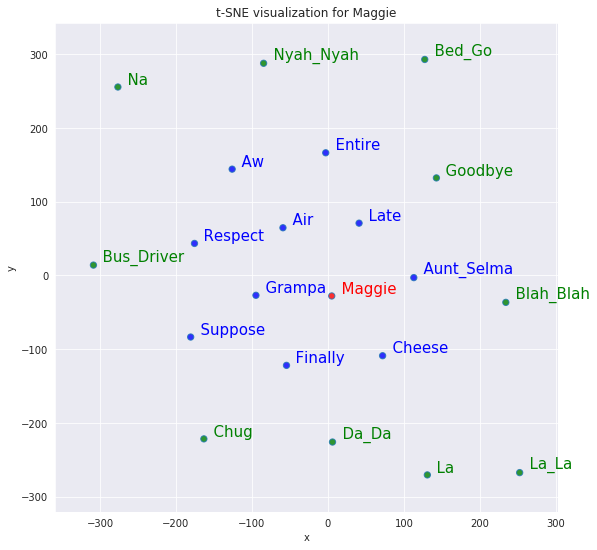

In [54]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

Neat! Maggie and her most similar words form a distinctive cluster from the most dissimilar words, it is a really encouraging plot!

## 10 Most similar words vs. 11th to 20th Most similar words:

Finally, we are going to plot the most similar words to Mr. Burns ranked 1st to 10th versus the ones ranked 11th to 20th:

(PS: Mr. Burns became mr_burn after the preprocessing)

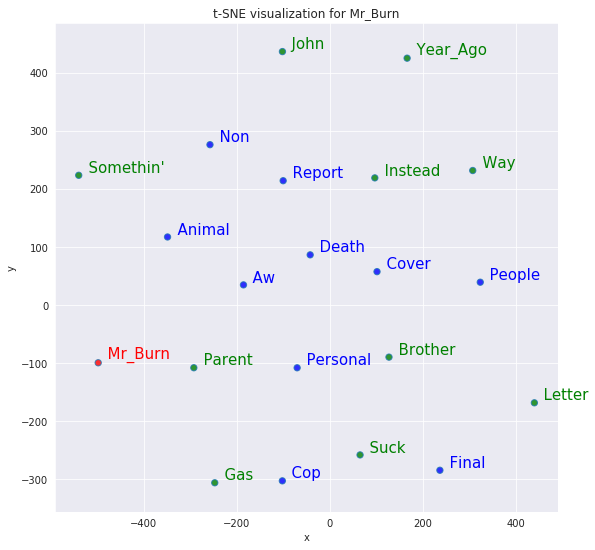

In [55]:
tsnescatterplot(w2v_model, "mr_burn", [t[0] for t in w2v_model.wv.most_similar(positive=["mr_burn"], topn=20)][10:])

As we can see, and that is very nice, all the 20 words are forming one cluster around Mr. Burns.

# Final Thoughts

I hope you found this tutorial useful and had as much fun reading it as I had writing it. Please do not hesitate to leave any comments, questions or suggestions you might have. See you around!

Also, please check [Supportiv](http://www.supportiv.com) around! (Simpson-ized logo)

<img src="https://fontmeme.com/permalink/180904/cc3d27a8aaa88189e764ee9d02331d0d.png" alt="drawing" width="500"/>


# Materials for more in depths understanding:
* Word Embeddings introduction: https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/
* Word2Vec introduction: https://skymind.ai/wiki/word2vec
* Another Word2Vec introduction: http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
* A great Gensim implentation tutorial: http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W467ScBjM2x
* Original articles from Mikolov et al.: https://arxiv.org/abs/1301.3781 and https://arxiv.org/abs/1310.4546


# Acknowledgements

* [Pouria Mojabi](https://www.linkedin.com/in/pouria-mojabi-1873615/), co-fouder of Supportiv Inc.

# References:
* [1]. Neural Net picture: McCormick, C. (2016, April 19). Word2Vec Tutorial - The Skip-Gram Model. Retrieved from http://www.mccormickml.com
* [2]. Aneesha Bakharia Medium article: https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229

# End
sources https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial